In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from deeplearning_train import EarlyStopping, ModelSaver
from deeplearning_train import plot_learning_loss_curves,train_regression_model
import os

In [5]:
# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(60%)、验证集(20%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)

训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


# 加载数据，构建模型

In [6]:
from torch import optim

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 30)
        self.activation = nn.ReLU()
        self.output = nn.Linear(30, 1)
        
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.output(x)
        return x

# 初始化模型、损失函数和优化器
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 打印模型结构
print(model)


RegressionModel(
  (layer1): Linear(in_features=8, out_features=30, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=30, out_features=1, bias=True)
)


In [7]:
# 评估模型
def evaluate_regression_model(model, dataloader,  device,criterion):
    model.eval()
    running_loss = 0.0

    
    with torch.no_grad():#禁止 autograd 记录计算图，节省显存与算力。
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs) #前向计算
            loss = criterion(outputs, targets) #计算损失
            
            running_loss += loss.item() * inputs.size(0)
    
    return running_loss / len(dataloader.dataset)

开始网格搜索最佳学习率...

尝试学习率: 0.01


train progress:   0%|          | 0/41300 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): -0.3099
早停: 已有10轮验证损失没有改善！
学习率 0.01 的验证损失: 0.4155


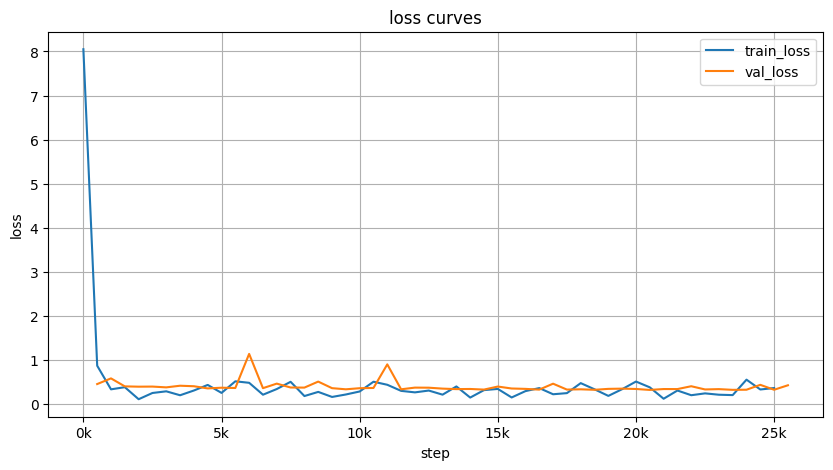


尝试学习率: 0.03


train progress:   0%|          | 0/41300 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): -0.3099
早停: 已有10轮验证损失没有改善！
学习率 0.03 的验证损失: 39.0397


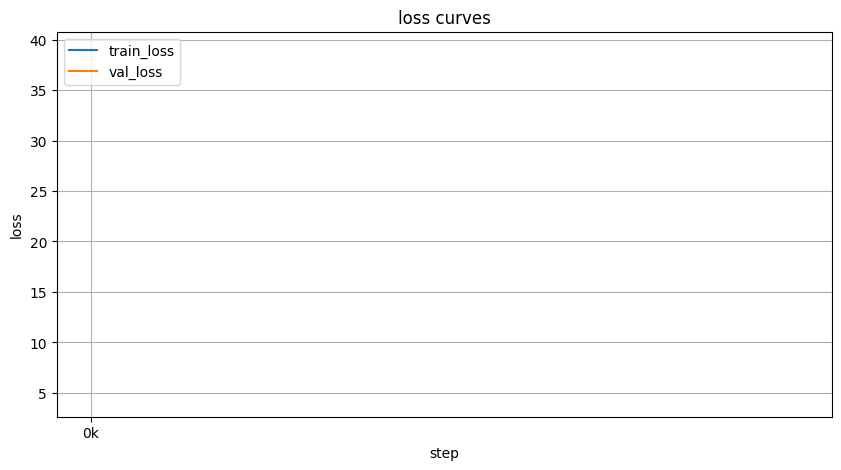


尝试学习率: 0.3


train progress:   0%|          | 0/41300 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): -0.3099
早停: 已有10轮验证损失没有改善！
学习率 0.3 的验证损失: 189.1953


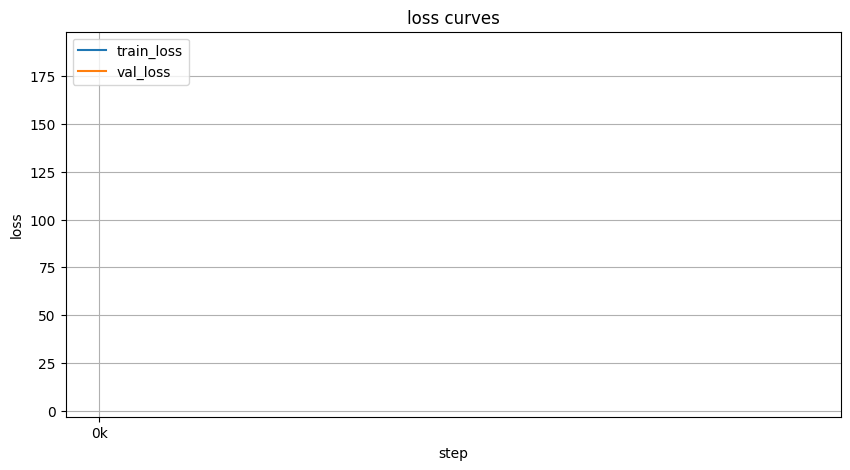


尝试学习率: 0.001


train progress:   0%|          | 0/41300 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): -0.3099
早停: 已有10轮验证损失没有改善！
学习率 0.001 的验证损失: 0.6792


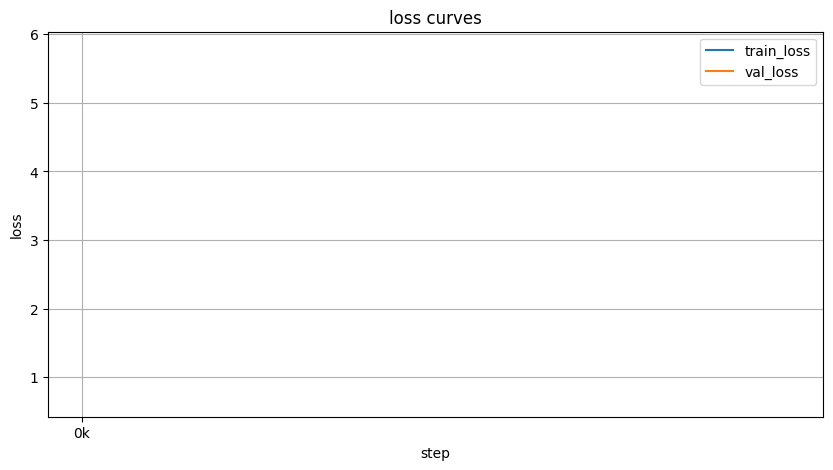


网格搜索完成！最佳学习率: 0.01, 最佳验证损失: 0.4155


In [8]:
# 定义回归模型训练函数



# 定义网格搜索函数进行超参数调优
learning_rates = [1e-2, 3e-2, 3e-1, 1e-3]  # 学习率列表
best_val_loss = float('inf')
best_model = None
best_lr = None
best_record_dict = None

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
early_stopping = EarlyStopping(patience=10)
model_saver = ModelSaver(save_dir='model_weights')

print("开始网格搜索最佳学习率...")
for lr in learning_rates:
    print(f"\n尝试学习率: {lr}")
    # 为每个学习率重新初始化模型
    model = RegressionModel(input_dim)
    # 使用当前学习率初始化优化器
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 训练模型
    current_model, record_dict = train_regression_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        print_every=10,
        eval_step=500,
        early_stopping=early_stopping,
        model_saver=model_saver,
        device=device
    )
    
    # 获取最后一个验证损失
    last_val_loss = record_dict["val"][-1]["loss"]
    print(f"学习率 {lr} 的验证损失: {last_val_loss:.4f}")
    
    # 画出当前学习率的学习曲线
    plot_learning_loss_curves(record_dict, sample_step=500)
    
    # 保存最佳模型
    if last_val_loss < best_val_loss:
        best_val_loss = last_val_loss
        best_model = current_model # 保存最佳模型
        best_lr = lr # 保存最佳学习率
        best_record_dict = record_dict # 保存最佳记录

print(f"\n网格搜索完成！最佳学习率: {best_lr}, 最佳验证损失: {best_val_loss:.4f}")
# 将最佳模型赋值给model变量以便后续使用
model = best_model
record_dict = best_record_dict

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_loss=evaluate_regression_model(model,test_loader,device,criterion)
print(f"测试集上的损失为{test_loss:.4f}")

测试集上的损失为0.3113
